# 1. Import Necessary Libraries

In [1]:
# Install Gradio for GUI
!pip install gradio

# Import libraries
import pandas as pd 
import tensorflow as tf 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import gradio as gr
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

# Import warnings and ignore warnings for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 8.8 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5600 sha256=dd417eb6e7228682137645a8df2458092d241a0d3bcecde5c940695f8b88bb67
  Stored in directory: /root/.cache/pip/wheels/81/c3/08/a4932aee56b934891932e4a1b189604f27d3d4e92b2ecd5ed4
Successfully built ffmpy
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.10.1
    Uninstalling huggingface-hub-0.10.1:
      Successfully uninstalled huggingface-hub-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the pack

# 2. Read the Dataset

**Read the Train CSV using Pandas Library**

In [2]:
# Dataset from: https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge

df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")

**Print the first 10 rows of the Comments Dataset**

In [3]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


**Print the last 10 rows of the Comments Dataset**

In [4]:
df.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


**Print the Toxicity Criteria that will be used for the model**

In [5]:
# List for toxicity criteria
toxicity_criteria = []; 

# For loop for getting the columns in dataset
for col in df.columns:
    
    # Add column name in toxicity criteria list
    toxicity_criteria.append(col)
    
# Delete the first two column names since it is not part of toxicity criteria
# Deleted columns: id and comment_text
del toxicity_criteria[:2] 

# Print the toxicity criteria list
print(toxicity_criteria)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


**Get the Data Correlation of Toxicity Criteria using corr() Function**

In [6]:
df.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


**Display the Comments Dataset Description using describe() Function**

In [7]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 3. Clean Comment Texts

**As you can see in the comment_text Column, it is messy and might be unreadable for the machine.**

In [8]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**Create a Function to Clean Comments**

In [9]:
# Clean Comments Function that gets text
def clean_comments(text):
    
    # Lowercase comment
    text = text.lower()
    
    # Replace words to clean
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    
    # Erase irrelevant characters
    text = text.replace('\\r', ' ')
    text = text.replace('\\n', ' ')
    text = text.replace('\\"', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    
    # Strip the sentence (remove first and last space character)
    text = text.strip(' ')
    
    # Return the cleaned text
    return text

**Use the Clean Comments Function to the comment_text Column using map() Function**

In [10]:
df['comment_text'] = df['comment_text'].map(lambda comment : clean_comments(comment))

**Display the Cleaned comment_text Column**

In [11]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i ca not make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


# 4. Display Samples of Non-toxic and Toxic Comments

> **WARNING !!!**
> 
> The following toxic (and worse) comments contains some foul, derogatory, or discriminatory language. The purpose of this section is to show you the difference between the 6 toxic criterias. You may skip this section if you wish not to see foul language.

**5 Examples of Not Toxic Comments**

In [12]:
df[df['toxic']==0].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i ca not make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


**5 Examples of Toxic Comments**

In [13]:
df[df['toxic']==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
12,0005c987bdfc9d4b,hey what is it talk what is it an exclusive gr...,1,0,0,0,0,0
16,0007e25b2121310b,bye do not look come or think of comming back ...,1,0,0,0,0,0
42,001810bf8c45bf5f,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1,0,1,0,1,0


**5 Examples of Severe Toxic Comments**

In [14]:
df[df['severe_toxic']==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
55,0020e7119b96eeeb,stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
181,006e87872c8b370c,you are a stupid fuck and your mother cunt stinks,1,1,1,0,1,0
442,01208d2b76624130,hi im a fucking bitch 50 180 208 181,1,1,1,0,1,0
579,018663f910e0bfe6,what a motherfucking piece of crap those fuckh...,1,1,1,0,1,0


**5 Examples of Obscene Comments**

In [15]:
df[df['obscene']==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
42,001810bf8c45bf5f,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1,0,1,0,1,0
51,001dc38a83d420cf,get fucked up get fuckeeed up got a drink that...,1,0,1,0,0,0
55,0020e7119b96eeeb,stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0


**5 Examples of Threat Comments**

In [16]:
df[df['threat']==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
79,003217c3eb469ba9,hi i am back again last warning stop undoing m...,1,0,0,1,0,0
176,006b94add72ed61c,i think that your a fagget get a oife and burn...,1,0,1,1,1,1
600,0199d6af27b715f3,i am also a sock puppet of this account supris...,1,0,0,1,0,0
802,02230885017a50c5,fuck you smith please have me notified when yo...,1,0,1,1,1,0
1017,02c6e41e4b317ac3,would not be the first time bitch fuck you i w...,1,1,1,1,1,1


**5 Examples of Insult Comment**

In [17]:
df[df['insult']==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
42,001810bf8c45bf5f,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1,0,1,0,1,0
55,0020e7119b96eeeb,stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,tony sidaway is obviously a fistfuckee he love...,1,0,1,0,1,0


**5 Examples of Identity Hate Comment**

In [18]:
df[df['identity_hate']==1].head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
42,001810bf8c45bf5f,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1
105,00472b8e2d38d1ea,a pair of jew hating weiner nazi schmucks,1,0,1,0,1,1
176,006b94add72ed61c,i think that your a fagget get a oife and burn...,1,0,1,1,1,1
218,008e0818dde894fb,kill all niggers i have hard that others have ...,1,0,1,0,1,1
238,0097dd5c29bf7a15,u r a tw fuck off u gay boy u r smelly fuck ur...,1,0,1,0,1,1


# 5. Visualizing the Dataset

**Get the Sum of Comments and Comments of Each Toxicity Criteria**

In [19]:
# Use len(df) for getting the total amount of comments (rows)
comments_sum = len(df)

# Use sum() function for getting the total amount of _____ comments (toxicity criteria)
toxic_sum = df[toxicity_criteria[0]].sum()
severe_toxic_sum = df[toxicity_criteria[1]].sum()
obscene_sum = df[toxicity_criteria[2]].sum()
threat_sum = df[toxicity_criteria[3]].sum()
insult_sum = df[toxicity_criteria[4]].sum()
identity_hate_sum = df[toxicity_criteria[5]].sum()

**Print the Sum of Comments and Comments of Each Toxicity Criteria**

In [20]:
# Convert comments_sum to string using str() function
print("Comments: " + str(comments_sum))


# Convert Sum of Toxicity Criteria to string using str() function
print("Toxic Comments: " + str(toxic_sum))
print("Severe Toxic Comments: " + str(severe_toxic_sum))
print("Obscene Comments: " + str(obscene_sum))
print("Threat Comments: " + str(threat_sum))
print("Insult Comments: " + str(insult_sum))
print("Identity Hate Comments: " + str(identity_hate_sum))

Comments: 159571
Toxic Comments: 15294
Severe Toxic Comments: 1595
Obscene Comments: 8449
Threat Comments: 478
Insult Comments: 7877
Identity Hate Comments: 1405


**Set Background Color for Seaborn Visualizations to Gray**

In [21]:
sns.set(rc={'axes.facecolor':'gray'})

**Visualize the Amount Difference of Toxic and Non-toxic Comments using Seaborn Countplot**

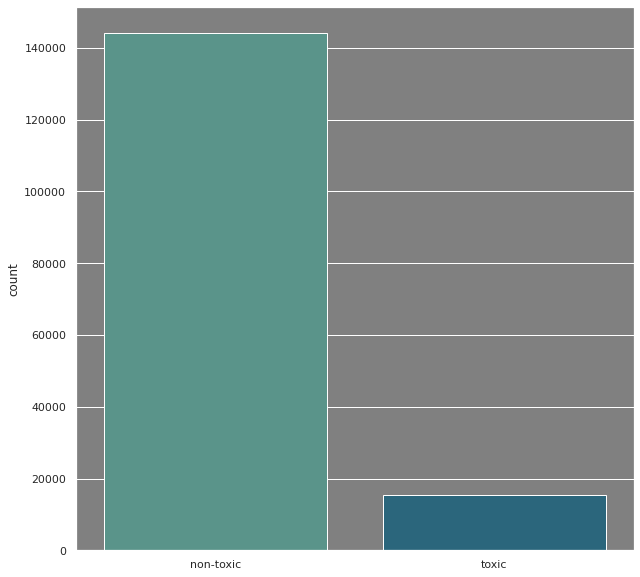

In [22]:
# List for Comments
comments = [];

# For loop for getting the toxic column in dataset
for comment in df['toxic']:
    
    # If comment value is 1 (comment is toxic)
    if (comment == 1):
        
        # Add Toxic Comments to Comments List
        comments.append("toxic");
        
    # Comment value must be 0 (comment is non-toxic)
    else:
        
        # Add Non-toxic Comments to Comments List
        comments.append("non-toxic");

# Set the figure size of Countplot Visualization to 10,10
fig, ax = plt.subplots(figsize=(10, 10))
        
# Create Countplot Visualization of Comments List
sns.countplot(x = comments, palette='crest', ax=ax);        

**Visualize the Amount Difference of Comments per Toxicity Criteria using Seaborn Barplot**

<AxesSubplot:title={'center':'Amount Difference of Comments per Toxicity Criteria'}>

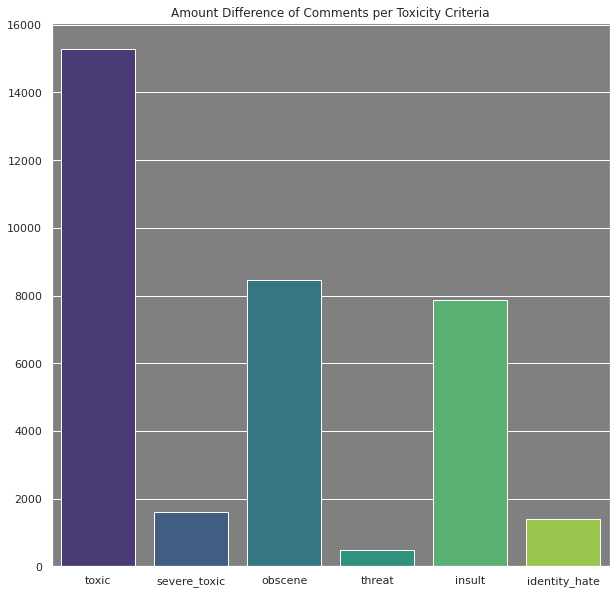

In [23]:
# List of Toxicity Sums
toxicity_sums = [toxic_sum, severe_toxic_sum, obscene_sum, threat_sum, insult_sum, identity_hate_sum]

# Set the figure size of Barplot Visualization to 10,10
fig, ax = plt.subplots(figsize=(10, 10))

# Set the figure title
plt.title('Amount Difference of Comments per Toxicity Criteria')

# Create Barplot Visualization of List of Toxicity Sums
sns.barplot(x=toxicity_criteria, y=toxicity_sums, palette='viridis', ax=ax)

**Visualize the Correlation of Toxicity Criteria with Each Other using Seaborn Heatmap**

<AxesSubplot:title={'center':'Correlation of Toxicity Criteria with Each Other'}>

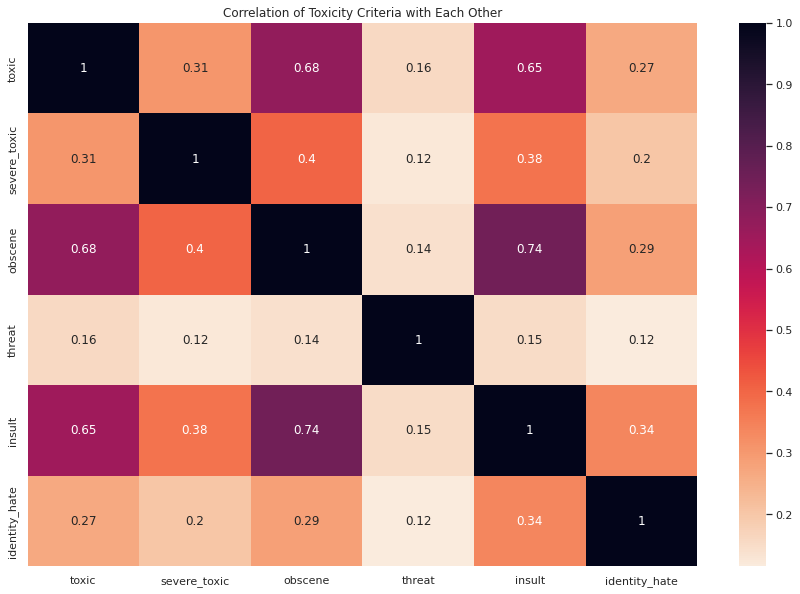

In [24]:
# Set the figure size of Heatmap Visualization to 15,10
fig, ax = plt.subplots(figsize=(15, 10))

# Set the figure title
plt.title('Correlation of Toxicity Criteria with Each Other')

# Create Heatmap Visualization of Toxicity Criteria
sns.heatmap(df[toxicity_criteria].corr(),cmap='rocket_r', annot=True)

# 6. Undersampling the Data

**As you saw in the Countplot Visualization, the Non-toxic Comments massively outweigh the Toxic Comments**

> Undersampling is a great way to have a symmetrical balance on dataset. This would greatly help the machine and lessen the space required to build the model.

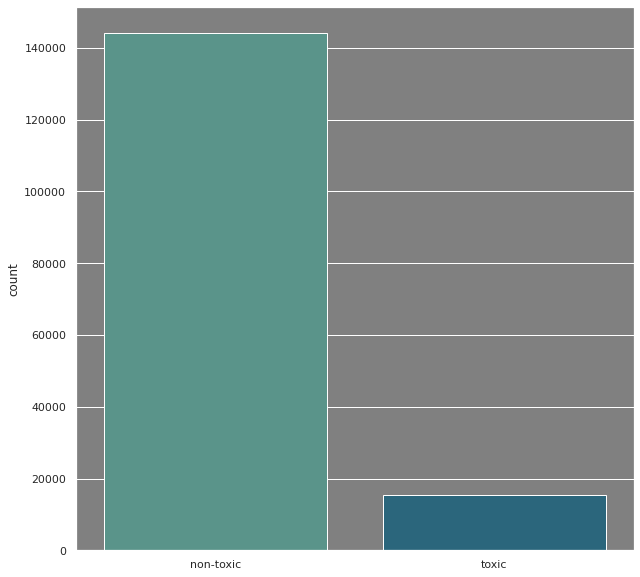

In [25]:
# Set the figure size of Countplot Visualization to 10,10
fig, ax = plt.subplots(figsize=(10, 10))
        
# Create Countplot Visualization of Comments List
sns.countplot(x = comments, palette='crest', ax=ax); 

**Make the Dataset Symmetrical using concat() Method**

In [26]:
# Get a number of non-toxic comments sample that is the same total amount of toxic comments using sample() Method
non_toxic_undersample = df[df['toxic'] == 0].sample(n=(df['toxic'] == 1).sum(), random_state=201)

# Use concat() Method to balance the sum of Toxic and Non-toxic Comments
df = pd.concat([df[df['toxic'] == 1], non_toxic_undersample])

**Visualize the Total Amount of Toxic and Non-toxic Comments using Seaborn Countplot**

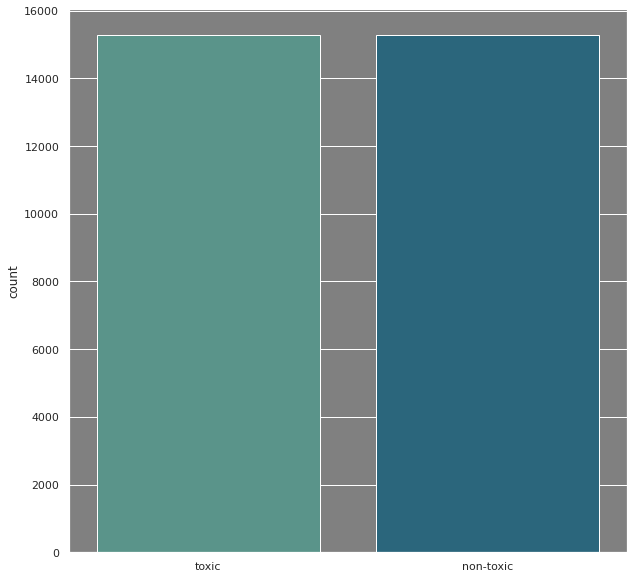

In [27]:
# List for Balanced Comments
balanced_comments = [];

# For loop for getting the toxic column in dataset
for comment in df['toxic']:
    
    # If comment value is 1 (comment is toxic)
    if (comment == 1):
        
        # Add Toxic Comments to Comments List
        balanced_comments.append("toxic");
        
    # Comment value must be 0 (comment is non-toxic)
    else:
        
        # Add Non-toxic Comments to Comments List
        balanced_comments.append("non-toxic");

# Set the figure size of Countplot Visualization to 10,10
fig, ax = plt.subplots(figsize=(10, 10))
        
# Create Countplot Visualization of Balanced Comments List
sns.countplot(x = balanced_comments, palette='crest', ax=ax);  

# 7. Preprocessing the Data

**Define X and y labels for the Data**

In [28]:
# Set X to the values of Comments Column
X = df['comment_text'].values

# Set y to the values of Toxicity Criteria Columns
y = df[toxicity_criteria].values

**Check for the Value of X**

In [29]:
print(X)

['cocksucker before you piss around on my work'
 'hey what is it talk what is it an exclusive group of some wp talibans who are good at destroying self appointed purist who gang up any one who asks them questions abt their anti social and destructive non contribution at wp ask sityush to clean up his behavior than issue me nonsensical warnings'
 'bye do not look come or think of comming back tosser' ...
 'comparisons i find it strange that the area of poland in the article is compared to that of new mexico i would think that americans would comprise only a small fraction of visitors of this page'
 'i removed material from del ponte that led nowhere that time has made irrelevant imo she signed the report june 2013 did not she that superseded her earlier remarks and left them pointless they were not in the least relevant to this article about ghouta if you find rs that link ghouta to her remarks of earlier in 2013 then fine but it just seems to me i removed a sentence that had no place i

**Check for the Value of y**

In [30]:
print(y)

[[1 1 1 0 1 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


**Create a Tokenizer for the Data**

> A tokenizer is a tool to map **text** into **integer** values for storing words in ease.

> My tokenizer has no maximum tokens limit, but has a maximum output sequence length of 3000.

> This modification will maximize my model accuracy.

In [31]:
tokenizer = TextVectorization(output_sequence_length=3000)

**Pass on Every Word of the Comments to the Tokenizer using adapt() Function**

In [32]:
tokenizer.adapt(X)

**Check the Words Tokenized using get_vocabulary() Function**

In [33]:
tokenizer.get_vocabulary

<bound method TextVectorization.get_vocabulary of <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7a94724fe810>>

**Create a Tokenized Words Variable and Tokenize the Comments using Tokenizer()**

In [34]:
tokenized_words = tokenizer(X)

**Get the Total Amount of Comments (value of X) using len() Function**

In [35]:
len(X)

30588

**Print the Tokenized Words**

> Take note of the shape (30588, 3000)

> **30588** is the Number of Comments

> **3000** is the Output Sequence Length in Tokenizer

> This proves that the Words have been Tokenized correctly

In [36]:
print(tokenized_words)

tf.Tensor(
[[ 411  161    3 ...    0    0    0]
 [ 231   37    9 ...    0    0    0]
 [1810   20   10 ...    0    0    0]
 ...
 [6111    4  182 ...    0    0    0]
 [   4  267  454 ...    0    0    0]
 [ 563    4   73 ...    0    0    0]], shape=(30588, 3000), dtype=int64)


**Map, Cache, Shuffle, Batch, and Prefetch the Data**

> Map - is for creating a tensorflow pipeline. Used when data is too large.

> Cache - store data in a cache memory

> Shuffle - passing through the buffer size (16000)

> Batch - groups data into 16 bacthes as samples

> Prefetch - prevents data congestion


> This 5 crucial steps is usually done with tokenization for breaking down the data in smaller bits

In [37]:
comment_data = tf.data.Dataset.from_tensor_slices((tokenized_words, y))
comment_data = comment_data.cache()
comment_data = comment_data.shuffle(160000)
comment_data = comment_data.batch(16)
comment_data = comment_data.prefetch(8)

**Print a Batch Sample in Comment Data using as_numpy_iterator() Function**

In [38]:
print(comment_data.as_numpy_iterator().next())

(array([[  51,  763,  219, ...,    0,    0,    0],
       [  83,    8,  557, ...,    0,    0,    0],
       [  15,  303,  474, ...,    0,    0,    0],
       ...,
       [  20,   10, 2719, ...,    0,    0,    0],
       [   9,   86, 1048, ...,    0,    0,    0],
       [   8,  510,    5, ...,    0,    0,    0]]), array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]]))


**Define Comment Batch X and y for showing the Data Batch Shape**

In [39]:
comm_batch_X, comm_batch_y = comment_data.as_numpy_iterator().next()

**Print Comment Batch X Shape**

> Batch X represents the batched words from comments 

> The shape (16, 3000) means (**number of batches**, **outline sequence length of Text Vectorization**)

In [40]:
print(comm_batch_X.shape)

(16, 3000)


**Print Comment Batch X Shape**

> Batch y represents the bnumber of values each token

> The shape (16, 6) means (**number of batches**, **number of values per token**)

In [41]:
print(comm_batch_y.shape)

(16, 6)


**Print the Total Amount of Samples per Batch**

In [42]:
print(len(comment_data))

1912


**Split the Data into Corresponding Percentage**

In [43]:
# Take 70% of Comment Data for training the model
# Use take() Function for getting the percentage of data
# Mulitply the Sum of Comment Data to 0.7 and convert it to int to get the 70% number of data
training_data = comment_data.take(int(len(comment_data) * 0.7))

# Take 20% of the remaining Comment Data for validating the data of the model
# Use skip() Function to skip the first 70% of Comment data using the Sum of Training Data 
# Use take() Function for getting the percentage of data
# Mulitply the Sum of Comment Data to 0.2 and convert it to int to get the 20% number of data
validating_data = comment_data.skip(len(training_data)).take(int(len(comment_data) * 0.2))

# Take 10% of the remaining Comment Data for testing the model
# Use skip() Function to skip the first 90% of Comment data  using the Sum of Training Data and Validating Data
# Use take() Function for getting the percentage of data
# Mulitply the Sum of Comment Data to 0.1 and convert it to int to get the 10% number of data
testing_data = comment_data.skip(len(training_data) + len(validating_data)).take(int(len(comment_data) * 0.1))

**Check the Total Amount of Training Data**

> The 70% of 1912 (Total Amount of Comment Data) is 1338

> This proves that the splitting of data is correct!

In [44]:
print(len(training_data))

1338


**Check the Total Amount of Validating Data**

> The 20% of 1912 (Total Amount of Comment Data) is 382

> This proves that the splitting of data is correct!

In [45]:
print(len(validating_data))

382


**Check the Total Amount of Testing Data**

> The 10% of 1912 (Total Amount of Comment Data) is 191

> This proves that the splitting of data is correct!

In [46]:
print(len(testing_data))

191


# 8. Build the Sequential Model

**Create Function for Creating the Sequential Model**

In [47]:
# Function for creating the Sequential Model
def create_Sequential_Model():
    
    # Set the model to Sequential
    seq_model = Sequential()
    
    
    # Use tensorflow keras layers for building the deep neural network
    
    
    # Add an embedding layer to the model
    # The embedding should have 300001 layers that will be 32 values long
    seq_model.add(Embedding(300001, 32))
    
    # Add a Bidirectional and LSTM Layer
    # The LSTM Layer has 32 units and tanh activation (used tanh because it's the only one accepted by LSTM)
    # The Bidirectional Layers allows the LSTM Layer to pass information in both directions
    seq_model.add(Bidirectional(LSTM(32, activation='tanh')))
    
    # Add 3 Connected Dense Layers
    # The Dense Layer has 128, 256, and 128 units and relu activations
    # These layers are used for extracting features
    seq_model.add(Dense(128, activation='relu'))
    seq_model.add(Dense(256, activation='relu'))
    seq_model.add(Dense(128, activation='relu'))
    
    # Add Dense Layer
    # This Special Dense Layer is for mapping the number of values per output (6)
    # The Layer has a sigmoid activation
    # Sigmoid is used for converting outputs from the previous layers to 0 and 1
    seq_model.add(Dense(6, activation='sigmoid'))
    
    # Compile the model and set the loss to BinaryCrossentropy
    # BinaryCrossentropy was used because the values vary from 0 to 1 only
    # Thus, making BinaryCrossentropy more effective on reducing loss
    # Set the optimizer to Adam 
    seq_model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])
    
    # Return the Sequential Model variable
    return seq_model

**Build the Model by calling the create_Sequential_Model Function**

In [48]:
model = create_Sequential_Model()

**Print the Model Summary for validation using summary() Function**

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          9600032   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 9,691,686
Trainable params: 9,691,686
Non-trainable params: 0
______________________________________________

# 9. Fit the Model to Data Training

**Create a History Variable and Fit the Model using fit() Function**

> In the fit() Function:

> Pass on the training_data variable

> Set the epochs to 10

> Set the Validation Data to the validating_data variable

In [50]:
history = model.fit(training_data, epochs=10, validation_data=validating_data)

Epoch 1/10
1338/1338 [==============================] - 242s 178ms/step - loss: 0.2305 - accuracy: 0.9961 - val_loss: 0.1706 - val_accuracy: 0.9959
Epoch 2/10
1338/1338 [==============================] - 238s 178ms/step - loss: 0.1665 - accuracy: 0.9967 - val_loss: 0.1678 - val_accuracy: 0.9969
Epoch 3/10
1338/1338 [==============================] - 238s 178ms/step - loss: 0.1544 - accuracy: 0.9965 - val_loss: 0.1357 - val_accuracy: 0.9954
Epoch 4/10
1338/1338 [==============================] - 238s 178ms/step - loss: 0.1387 - accuracy: 0.9964 - val_loss: 0.1238 - val_accuracy: 0.9962
Epoch 5/10
1338/1338 [==============================] - 238s 178ms/step - loss: 0.1266 - accuracy: 0.9967 - val_loss: 0.1089 - val_accuracy: 0.9964
Epoch 6/10
1338/1338 [==============================] - 238s 178ms/step - loss: 0.1122 - accuracy: 0.9966 - val_loss: 0.1047 - val_accuracy: 0.9969
Epoch 7/10
1338/1338 [==============================] - 238s 178ms/step - loss: 0.1039 - accuracy: 0.9962 - val_

**Show the Raw History Array Result**

In [51]:
history.history

{'loss': [0.23051664233207703,
  0.16648054122924805,
  0.1543891578912735,
  0.13874311745166779,
  0.1265883445739746,
  0.1122031882405281,
  0.10393758863210678,
  0.08835838735103607,
  0.08083079010248184,
  0.07212629169225693],
 'accuracy': [0.996076226234436,
  0.9966834783554077,
  0.9964966177940369,
  0.9964499473571777,
  0.9966834783554077,
  0.9966367483139038,
  0.996216356754303,
  0.9962630867958069,
  0.972673773765564,
  0.9387145042419434],
 'val_loss': [0.17064602673053741,
  0.16778229176998138,
  0.1356699913740158,
  0.12378282099962234,
  0.10885104537010193,
  0.10466944426298141,
  0.08485715091228485,
  0.07824289053678513,
  0.06793784350156784,
  0.06391297280788422],
 'val_accuracy': [0.9959096908569336,
  0.9968913793563843,
  0.9954188466072083,
  0.9962369203567505,
  0.9964005351066589,
  0.9968913793563843,
  0.9970549941062927,
  0.996073305606842,
  0.9973822236061096,
  0.9962369203567505]}

**Show Model Accuracy using Matplotlib Pyplot Graph**

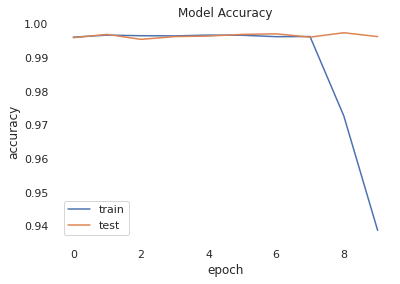

In [52]:
sns.set(rc={'axes.facecolor':'white'})

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

**Show Model Loss using Matplotlib Pyplot Graph**

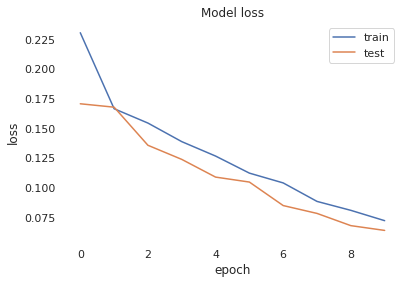

In [53]:
sns.set(rc={'axes.facecolor':'white'})

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# 10. Predict the Model

**Create a Test Comment for Predicting the Model**

> Use the tokenizer to tokenize the phrase "I hate you, you fat pig!"

In [54]:
test_comment = tokenizer("I hate you, you fat pig!")

**Create a Test Variable and Predict the Model using predict() Function**

> Use the np.array() Function to make the test comment into numpy array

In [55]:
test = model.predict(np.array([test_comment]))

**Print the Toxicity Criteria Once Again**

In [56]:
toxicity_criteria

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

**Print the Result of the Test Variable**

> The following values are the result evaluation of the toxic comment detector model

> The following array also follows the order toxicity criteria

> The values, in order, means: toxic, severe_toxic, obscene, threat, insult, identity_hate

> If the value is more than 0.5, then the comment passes that certain toxicity criteria

In [57]:
test

array([[0.9967686 , 0.07094533, 0.47257826, 0.02849133, 0.8698157 ,
        0.34771708]], dtype=float32)

**Print the Result of the Test Variable in Boolean Form**

> Check first if Test Value is above 0.5

> Use the astype() Function and pass on bool as the parameter

In [58]:
(test > 0.5).astype(bool)

array([[ True, False, False, False,  True, False]])

**Define Comment Batch X and y for Predicting the Model using Validating Data**

> Use as_numpy_iterator() Function to print a batch from validating_data

In [59]:
comm_batch_X, comm_batch_y = validating_data.as_numpy_iterator().next()

**Create a Test Data Model Variable and Predict the Model using predict() Function**

> Pass in the Comment Batch X

In [60]:
test_data_model = model.predict(comm_batch_X)

**Print the Result of the Test Variable in Boolean Form**

> Check first if Test Value is above 0.5

> Use the astype() Function and pass on bool as the parameter

In [61]:
(test_data_model > 0.5).astype(bool)

array([[ True, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True,  True,  True, False,  True, False],
       [False, False, False, False, False, False],
       [ True, False,  True, False,  True, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

# 11. Evaluate the Model

**Evaluate the Model using evaluate() Method and Pass on the training_data Variable**

In [62]:
modelScore = model.evaluate(training_data, verbose=0)

**Print the Model Loss by Displaying modelScore[0]**

In [63]:
print('Model Loss:', modelScore[0])

Model Loss: 0.06366254389286041


**Print the Model Accuracy by Displaying modelScore[1]**

In [64]:
print('Model Accuracy:', modelScore[1])

Model Accuracy: 0.9961229562759399


# 12. Save and Test the Model

**Save the Model as toxic_comment_detector.h5 using save() Function**

In [65]:
model.save('toxic_comment_detector.h5')

**Load the Model using load_model() Function from Keras**

In [66]:
model = tf.keras.models.load_model('toxic_comment_detector.h5')

**Test the Model using predict() Function with the test_comment Variable**

> Use the array() Function from Numpy to transform the test_comment to Numpy Array

In [67]:
test_saved_model = model.predict(np.array([test_comment]))

**Print the Result of the Test Variable in Boolean Form**

> Check first if Test Value is above 0.5

> Use the astype() Function and pass on bool as the parameter

In [68]:
(test_saved_model > 0.5).astype(bool)

array([[ True, False, False, False,  True, False]])

# 13. Create a GUI for the Model using Gradio

**Create Evaluate Comment Function for the GUI**

In [69]:
# Create evaluate comment function and take the comment as the parameter
def evaluate_comment(comment):
    
    # Tokenize the comment using the tokenizer() Method
    # Place the comment in [] brackets because the Method requires 2D array
    tokenized_comment = tokenizer([comment])
    
    # Predict the Tokenized Comment and place it on the Result Variable
    result = model.predict(tokenized_comment)
    
    
    ### START TEXT OUTPUT
    
    # Declare the Text that is to be displayed in the GUI
    # Add the Text "Your comment seems to be:" as the Heading for the Output
    text = 'Your comment seems to be:\n'
    
    
    
    ### LIST TEXT OUTPUT
    
    # For loop that loops through the Toxicity Criteria
    for index, column in enumerate(df[toxicity_criteria]):
        
        # Check if the loop is in Toxic Column
        if column == 'toxic':
            
            # Check if Comment Toxic Result is more than 0.5 (toxic)
            if result[0][index] > 0.5:
                
                # Add Toxic to the Output
                text += '- Toxic\n'
                
            # Comment Toxic Result must be less than 0.5 (not toxic)
            else:
                
                # Add Non-toxic to the Output
                text += '- Non-toxic\n'
              
        # Check if the loop is in Severe Toxic Column    
        elif column == 'severe_toxic':
            
            # Check if Comment Severe Toxic Result is more than 0.5 (severe_toxic)
            if result[0][index] > 0.5:
                
                # Add Severely Toxic to the Output
                text += '- Severely Toxic\n'
             
        # Check if the loop is in Obscene Column     
        elif column == 'obscene':
            
            # Check if Comment Obscene Result is more than 0.5 (obscene)
            if result[0][index] > 0.5:
                
                # Add Obscene to the Output
                text += '- Obscene\n'   
                
        # Check if the loop is in Threat Column 
        elif column == 'threat':
            
            # Check if Comment Threat Result is more than 0.5 (threatening)
            if result[0][index] > 0.5:
                
                # Add Threatening to the Output
                text += '- Threatening\n'
                
        # Check if the loop is in Insult Column 
        elif column == 'insult':
            
            # Check if Comment Insult Result is more than 0.5 (offensive)
            if result[0][index] > 0.5:
                
                # Add Offensive to the Output
                text += '- Offensive\n'
            
        # Check if the loop is in Identity Hate Column 
        elif column == 'identity_hate':
            
            # Check if Comment Identity Hate Result is more than 0.5 (racist)
            if result[0][index] > 0.5:
                
                # Add Racist to the Output
                text += '- Racist\n'
                
                
    ### END TEXT OUTPUT
                
    # Check if Comment Toxic Result is more than 0.5 (toxic)
    if result[0][0] > 0.5:
        
        # Add "No need to be toxic! Being nice won't hurt you" with a grimacing face emoji to the Output
        text += "\n\nNo need to be toxic! Being nice won't hurt you \N{grimacing face}"
        
    # Comment Toxic Result must be less than 0.5 (not toxic)
    else:
        
        # Add "Keep it up!" with a grinning face and thumbs up emojis to the Output
        text += "\n\nKeep it up! \N{grinning face}"
    
    
    # Return the Output Text
    return text

**Create the Gradio GUI using Interface() Function**

In [70]:
!pip install gradio
import gradio as gr

In [71]:
import gradio as gr

def evaluate_comment(comment):
    # Your evaluation logic here
    return "The evaluation result"

GradioGUI = gr.Interface(
    fn=evaluate_comment,  # Pass on evaluate_comment Function
    inputs=gr.inputs.Textbox(lines=5, placeholder='Enter your comment...'),  # Create Input Textbox that will be passed on to the evaluate_comment Function
    outputs='text',  # Set the Outputs to text variable
    title='Toxic Comment Detector',  # Set the title
    description='A machine learning project that detects if your comment is toxic or not',  # Set the description
    css='''span{text-transform: uppercase} p{text-align: center}'''  # Modify some CSS for the texts
)

GradioGUI.launch()


Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://ac9b65e8e7ce4ba2b8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**Launch the Gradio GUI using lanuch() Function**

> Set the share to True so that there will be a shareable public URL of the interface

In [72]:
GradioGUI.launch(share=True)

# The public URL is most probably expired when you are checking this.
# I recommend you to run the code again to generate your own public URL

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://ac9b65e8e7ce4ba2b8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
